Covid Patient Lung image


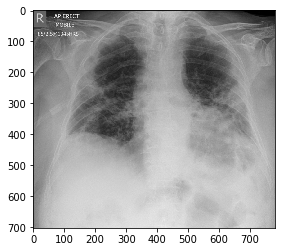

In [6]:
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import cv2

image = load_img("dataset\covid\covid-19-pneumonia-42.JPEG")
print("Covid Patient Lung image")
plt.imshow(image)

In [7]:
data = []
labels = []
filenames1=glob.glob('dataset\covid\*.JPEG')
filenames2=glob.glob('dataset\covid\*.JPG')
filenames3=glob.glob('dataset\covid\*.PNG')
filenames4=glob.glob(r'C:\Users\GTR\Downloads\Covid\dataset\normal\*.JPEG')
filenames=filenames1+filenames2+filenames3+filenames4
# loop over the image paths
for imagePath in filenames:
# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

# load the image, swap color channels, and resize it to be a fixed
# 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

# update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [8]:
from collections import Counter
print(Counter(labels).keys())
print(Counter(labels).values())

dict_keys(['covid', 'normal'])
dict_values([51, 61])


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3
from tensorflow.keras.layers import AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os



INIT_LR = 1e-2
EPOCHS = 21
BS = 3
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.3, stratify=labels, random_state=42)


# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")
    
trainAug.fit(trainX)

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS,save_to_dir='Augumented_Images', save_prefix='aug_rotation', save_format='png'),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Use tf.cast instead.
Epoch 1/21
26/26 [==============================] - 60s 2s/step - loss: 0.4788 - acc: 0.8205 - val_loss: 0.1939 - val_acc: 0.9412
Epoch 2/21
26/26 [==============================] - 57s 2s/step - loss: 0.6518 - acc: 0.7179 - val_loss: 0.4015 - val_acc: 0.7647
Epoch 3/21
26/26 [==============================] - 57s 2s/step - loss: 0.3873 - acc: 0.8462 - val_loss: 0.1682 - val_acc: 1.0000
Epoch 4/21
26/26 [==============================] - 58s 2s/step - loss: 0.4037 - acc: 0.8462 - val_loss: 0.6594 - val_acc: 0.5294
Epoch 5/21
26/26 [==============================] - 56s 2s/step - loss: 0.4713 - acc: 0.7821 - val_loss: 0.3751 - val_acc: 0.7059
Epoch 6/21
26/26 [==============================] - 56s 2s/step -

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        15
      normal       1.00      1.00      1.00        19

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



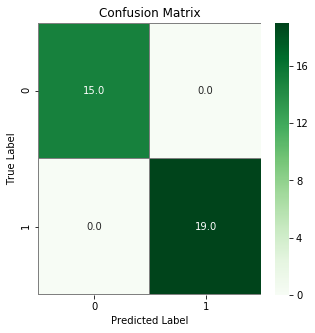

acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
F1score: 1.0000


In [10]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
Precision=cm[0, 0] / (cm[0, 0] + cm[1, 0])
F1Score=((Precision*sensitivity)/(sensitivity+Precision)) * 2

# compute the confusion matrix
confusion_mtx = confusion_matrix(testY.argmax(axis=1), predIdxs) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
print("F1score: {:.4f}".format(F1Score))

[INFO] saving COVID-19 detector model...


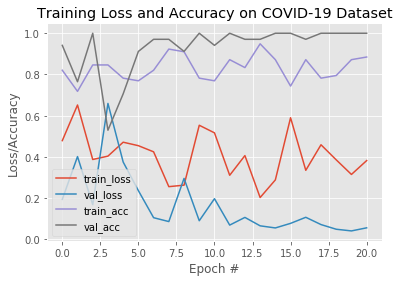

In [11]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save('model.h5')